# Feature Extraction

In [19]:
# imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))

# Load the dataset
trainingSet = pd.read_csv("train.csv")

# Reducing sample size to 10% - random sampling 
trainingSet = trainingSet.sample(frac=0.1)
#trainingSet = trainingSet.head(50)

# Handeling missing values 
# (1) Remove rows with null score values 
trainingSet = trainingSet[trainingSet['Score'].notnull()]

trainingSet.head(5)
trainingSet.columns

# takes 22.9s to run


Index(['Id', 'ProductId', 'UserId', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [20]:

# feature extraction method:

print("columns before feature extraction: ")
print(trainingSet.columns)


# (1) converting all float values to strings in summary and text column
trainingSet["Summary"] = trainingSet["Summary"].values.astype('str')
trainingSet["Text"] = trainingSet["Text"].values.astype('str')


def extract_features(df):
    # This is where you can do all your processing

    # (0) Pre-processing Step: Drop rows where helpfullness numerator is more than denominator
    df = df[df.HelpfulnessNumerator <= df.HelpfulnessDenominator ]

    # (1) Helpfulness - feature extraction
    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)

    # (2) Unhelpfulness - feature extraction
    df['UnHelpfulness'] = (df['HelpfulnessDenominator'] - df['HelpfulnessNumerator'])/ df['HelpfulnessDenominator']
    df['UnHelpfulness'] = df['Helpfulness'].fillna(0)

    # (3) Average Score written by each UserId
    df['UserAvgScore'] = df.groupby('UserId')['Score'].transform('mean')
    df['UserAvgScore'] = df['UserAvgScore'].fillna(0)

    # (4) counting the number of uppercase characters in reviews
    df['NumUppercase_T'] = df['Text'].str.findall(r'[A-Z]').str.len()
    df['NumUppercase_S'] = df['Summary'].str.findall(r'[A-Z]').str.len()

    # (5) ReviewLength - feature extraction
    df['ReviewLength'] = df.Text.str.split().str.len()
    df['ReviewLength'] = df['ReviewLength'].fillna(0)

    # (6) SummaryLength - feature extraction
    df['SummaryLength'] = df.Summary.str.split().str.len()
    df['SummaryLength'] = df['SummaryLength'].fillna(0)

    # (7) Time Stamps - feature extraction
    df['Date'] = pd.to_datetime(trainingSet['Time'], unit='s')
    #df['Hour'] = df['Date'].dt.hour
    df['Month'] = df['Date'].dt.month
    df['Year'] = df['Date'].dt.year

    # (8) Counting the number of times an exclamation occurs in a review - feature extraction
    sub = "!"
    df['numExclamation_S'] = df['Summary'].str.count(sub)
    df['numExclamation_T'] = df['Text'].str.count(sub)

    # (9) removing stop words (pre-processing step)
    df['Summary']= df['Summary'].apply(lambda x: remove_stopwords(x))
    df['Text']= df['Text'].apply(lambda x: remove_stopwords(x))



    return df

# helper function for removing stop words:
stopwords = nltk.corpus.stopwords.words('english')
def remove_stopwords(text):
    stopwords_removed= [i for i in text if i not in stopwords]
    return stopwords_removed

trainingSet = extract_features(trainingSet)
print("columns after feature extraction: ")
print(trainingSet.columns)

# takes 1m 56.1s to run (with 9 features)
# takes ~ 8 mins to run

columns before feature extraction: 
Index(['Id', 'ProductId', 'UserId', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')


/var/folders/28/k_0b83n90054zf3kf809sw6m0000gp/T/ipykernel_54692/1522588810.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
/var/folders/28/k_0b83n90054zf3kf809sw6m0000gp/T/ipykernel_54692/1522588810.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Helpfulness'] = df['Helpfulness'].fillna(0)
/var/folders/28/k_0b83n90054zf3kf809sw6m0000gp/T/ipykernel_54692/1522588810.py:23: SettingWithCopyWarning: 
A value is trying to

columns after feature extraction: 
Index(['Id', 'ProductId', 'UserId', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text',
       'Helpfulness', 'UnHelpfulness', 'UserAvgScore', 'NumUppercase_T',
       'NumUppercase_S', 'ReviewLength', 'SummaryLength', 'Date', 'Month',
       'Year', 'numExclamation_S', 'numExclamation_T'],
      dtype='object')


/var/folders/28/k_0b83n90054zf3kf809sw6m0000gp/T/ipykernel_54692/1522588810.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Text']= df['Text'].apply(lambda x: remove_stopwords(x))


# Further Feature Extraction - Sentiment Analysis 

In [21]:
# imports
from nltk.sentiment import SentimentIntensityAnalyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# sentiment analysis on Review Text
sia = SentimentIntensityAnalyzer()
res = {}
for i, row in trainingSet.iterrows():
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)

vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns = {'index':"Id"})
trainingSet = pd.merge(trainingSet, vaders, left_on='Id', right_on='Id')

# takes 3m 39.4s to run

In [23]:
trainingSet.columns

Index(['Id', 'ProductId', 'UserId', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text',
       'Helpfulness', 'UnHelpfulness', 'UserAvgScore', 'NumUppercase_T',
       'NumUppercase_S', 'ReviewLength', 'SummaryLength', 'Date', 'Month',
       'Year', 'numExclamation_S', 'numExclamation_T', 'neg', 'neu', 'pos',
       'compound'],
      dtype='object')

In [24]:
# Save the updated dataset into a new CSV file
trainingSet.to_csv('new_feauturesExtracted_dataset.csv', index=False)

# Further Data Exploration

In [26]:
trainingSet.shape

(139650, 25)

In [27]:
trainingSet.describe

<bound method NDFrame.describe of              Id   ProductId          UserId  HelpfulnessNumerator  \
0        474510  630573240X  A14ZLQAJI6AAM1                     0   
1       1296821  B002WH0ZAE  A2FRKEXDXDN1KI                    14   
2       1603135  B009XTF8GK   A2MU9J525H1HC                     3   
3        722748  B00006RJCS  A28B7IJR80M8KE                     0   
4       1433644  B004YM6JI2   A6QH5AQGWJNA8                     0   
...         ...         ...             ...                   ...   
139645  1663948  B00E3UN44W  A1B86KQ1OFHCBC                     2   
139646   690694  B00005YUO1  A3E8A20RMVFARI                     0   
139647   920528  B000A3XY5A  A1FXPZ5K1C1NBY                     4   
139648   347548  6302962048  A2ZYV5WM4YZZFG                     3   
139649    42698  0783113145   ASIA7V7CBSKD3                     6   

        HelpfulnessDenominator  Score        Time  \
0                            0    5.0  1367971200   
1                           16 

                 neg            neu            pos       compound
count  139650.000000  139650.000000  139650.000000  139650.000000
mean        0.005075       0.951800       0.043125       0.392294
std         0.018314       0.059083       0.055513       0.412980
min         0.000000       0.000000       0.000000      -0.997800
25%         0.000000       0.931000       0.000000       0.000000
50%         0.000000       0.964000       0.030000       0.458800
75%         0.000000       1.000000       0.061000       0.771700
max         1.000000       1.000000       1.000000       0.999700


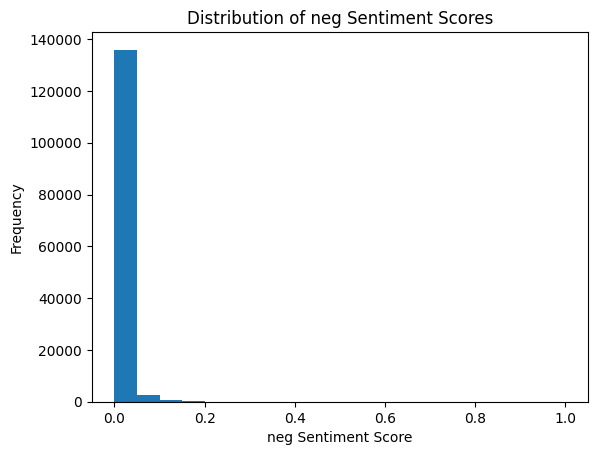

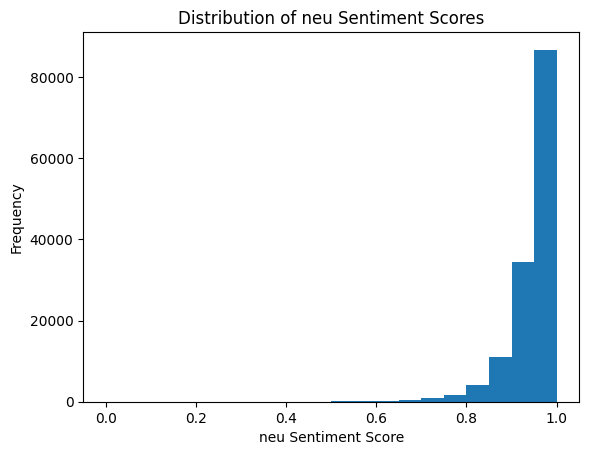

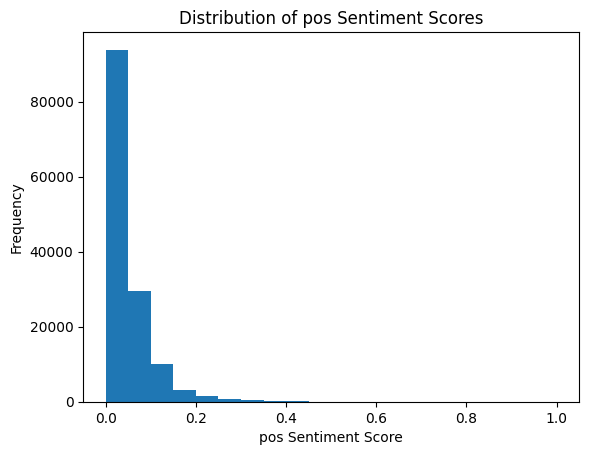

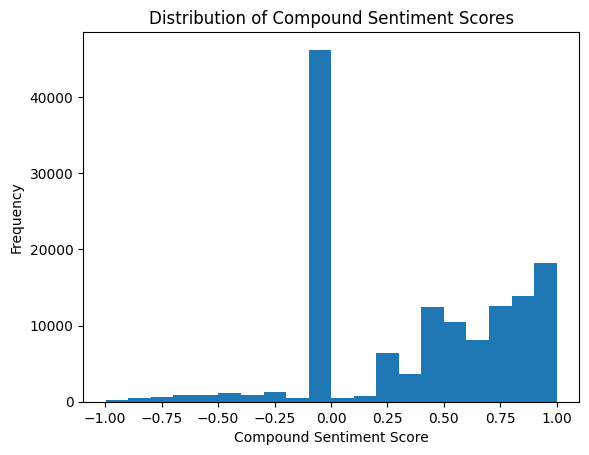

In [29]:
# Create a new dataframe that contains only the sentiment columns
sentiment_df = trainingSet[['neg', 'neu', 'pos', 'compound']]

# Get summary statistics of the sentiment scores
print(sentiment_df.describe())

# Create a histogram of the 'neg' column
plt.hist(sentiment_df['neg'], bins=20)
plt.xlabel('neg Sentiment Score')
plt.ylabel('Frequency')
plt.title('Distribution of neg Sentiment Scores')
plt.show()

# Create a histogram of the 'neu' column
plt.hist(sentiment_df['neu'], bins=20)
plt.xlabel('neu Sentiment Score')
plt.ylabel('Frequency')
plt.title('Distribution of neu Sentiment Scores')
plt.show()

# Create a histogram of the 'pos' column
plt.hist(sentiment_df['pos'], bins=20)
plt.xlabel('pos Sentiment Score')
plt.ylabel('Frequency')
plt.title('Distribution of pos Sentiment Scores')
plt.show()

# Create a histogram of the 'compound' column
plt.hist(sentiment_df['compound'], bins=20)
plt.xlabel('Compound Sentiment Score')
plt.ylabel('Frequency')
plt.title('Distribution of Compound Sentiment Scores')
plt.show()

/var/folders/28/k_0b83n90054zf3kf809sw6m0000gp/T/ipykernel_54692/4154770890.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  helpful_df['HelpfulnessRatio'] = helpful_df['HelpfulnessNumerator'] / helpful_df['HelpfulnessDenominator']


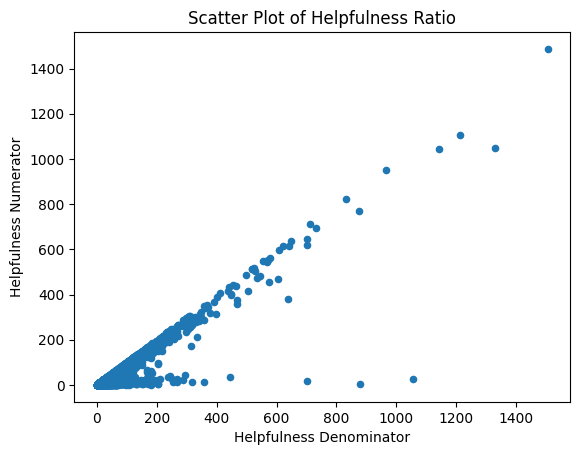

In [30]:
# Create a new dataframe that contains only the 'HelpfulnessNumerator' and 'HelpfulnessDenominator' columns
helpful_df = trainingSet[['HelpfulnessNumerator', 'HelpfulnessDenominator']]

# Create a new column that calculates the ratio of helpfulness
helpful_df['HelpfulnessRatio'] = helpful_df['HelpfulnessNumerator'] / helpful_df['HelpfulnessDenominator']

# Create a scatter plot of the 'HelpfulnessNumerator' and 'HelpfulnessDenominator' columns
helpful_df.plot(kind='scatter', x='HelpfulnessDenominator', y='HelpfulnessNumerator')
plt.xlabel('Helpfulness Denominator')
plt.ylabel('Helpfulness Numerator')
plt.title('Scatter Plot of Helpfulness Ratio')
plt.show()

Text(0.5, 1.0, 'Busiest Months for Reviews')

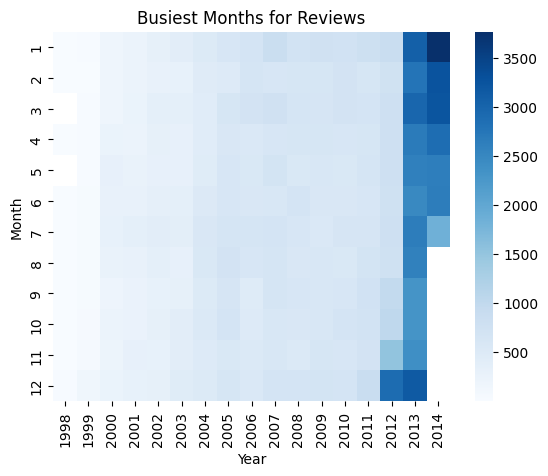

In [7]:
import seaborn as sns

# group the data by month and year
reviews_by_month_year = trainingSet.groupby(['Month', 'Year'])['Id'].count()

# reshape the data
heatmap_data = reviews_by_month_year.unstack()

# create the heatmap
ax = sns.heatmap(heatmap_data, cmap='Blues')
ax.set_title('Busiest Months for Reviews')

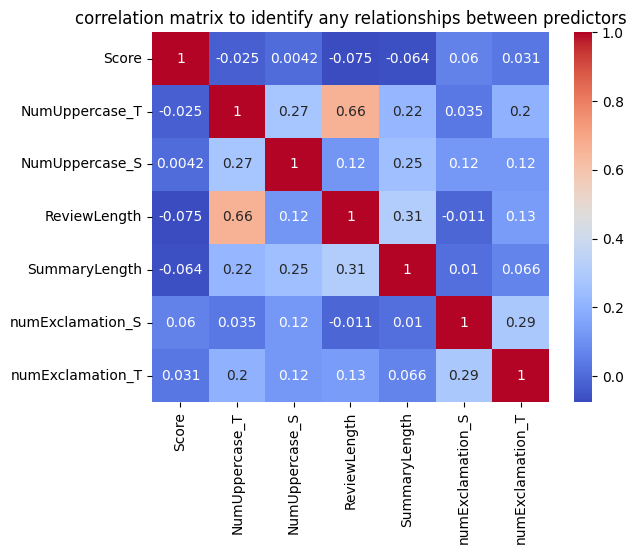

In [8]:
# correlation matrix

# select the columns to include in the correlation matrix
cols = ['Score', 'NumUppercase_T', 'NumUppercase_S', 'ReviewLength', 'SummaryLength', 'numExclamation_S', 'numExclamation_T' ]

# calculate the correlation matrix
corr_matrix = trainingSet[cols].corr()

# visualize the correlation matrix using a heatmap
ax = sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
ax.set_title('correlation matrix to identify any relationships between predictors')

# display the heatmap
plt.show()

# takes 1.4s

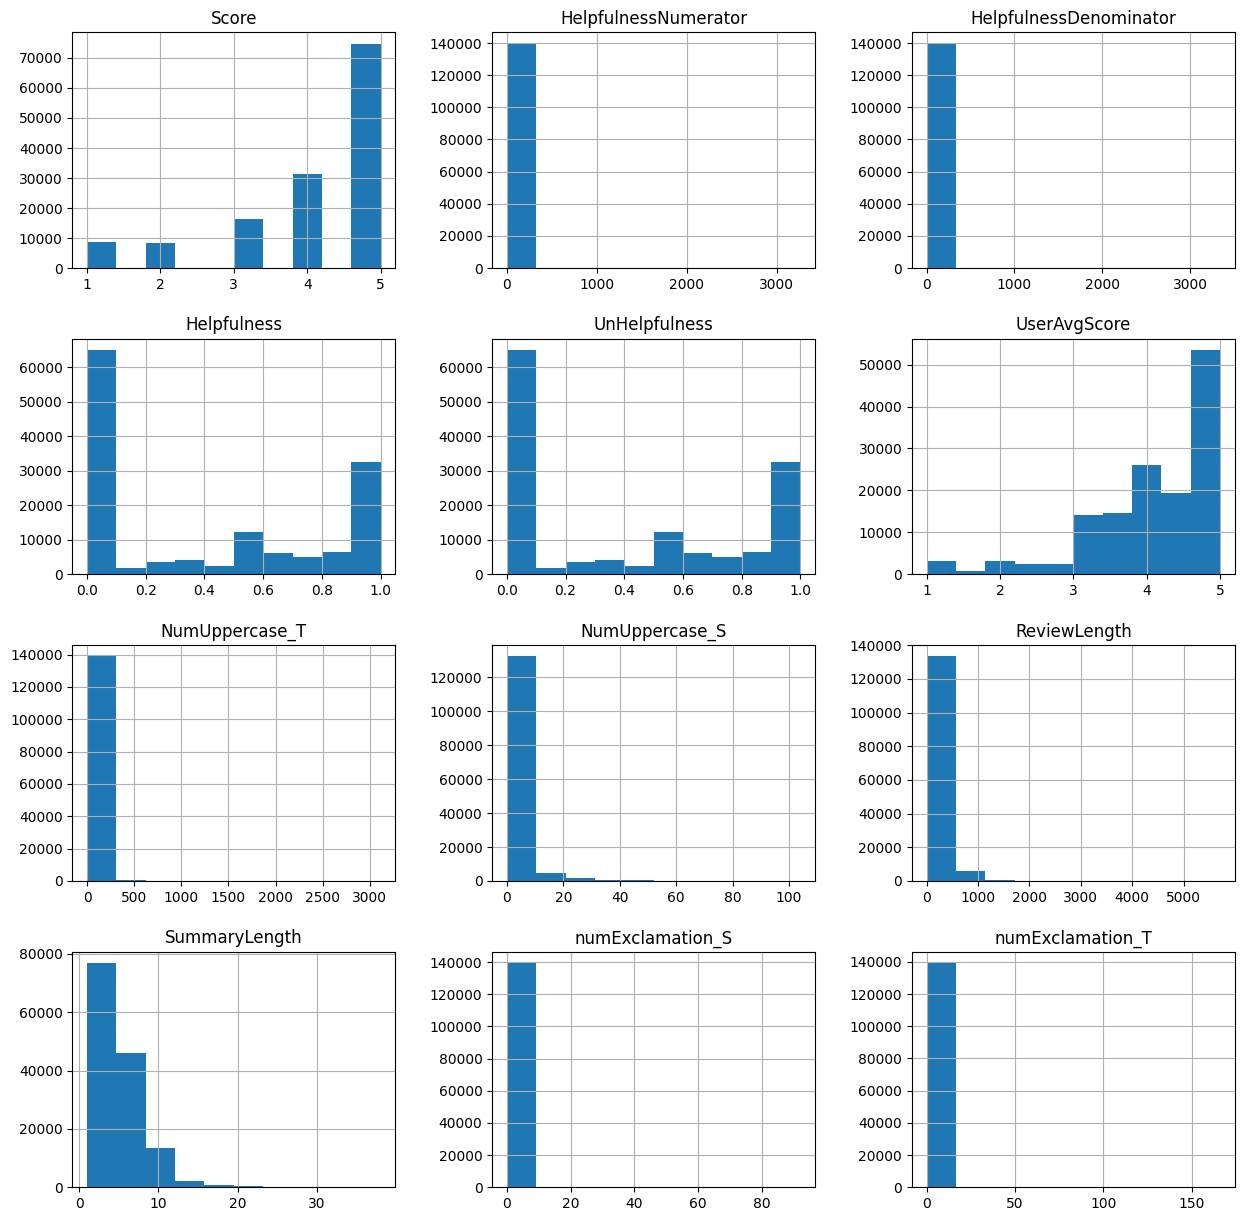

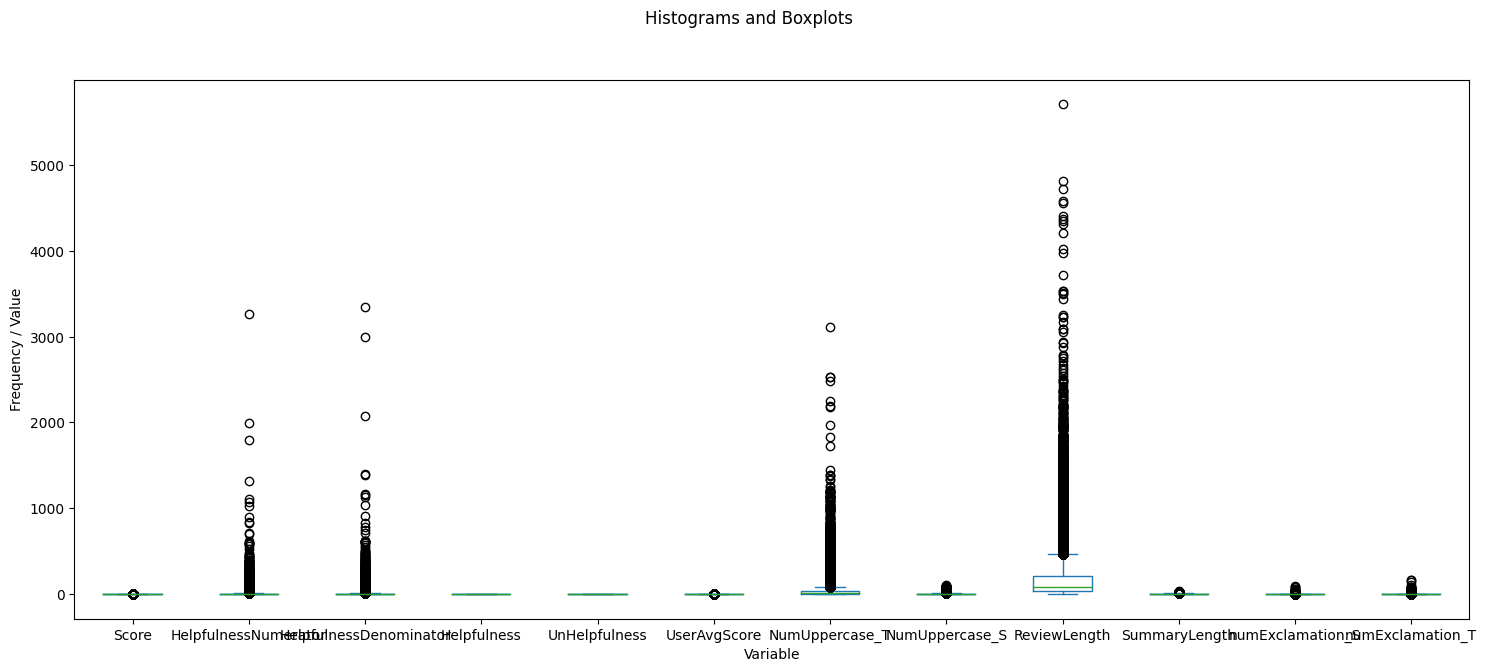

In [18]:
# select the columns to include in the histograms and boxplots
cols = ['Score', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Summary', 'Text',
       'Helpfulness', 'UnHelpfulness', 'UserAvgScore', 'NumUppercase_T',
       'NumUppercase_S', 'ReviewLength', 'SummaryLength', 'numExclamation_S', 'numExclamation_T']

# plot histograms for the selected columns
trainingSet[cols].hist(figsize=(15, 15))

# plot boxplots for the selected columns
trainingSet[cols].plot(kind='box', figsize=(18, 7))

# set the plot title and axis labels
plt.suptitle('Histograms and Boxplots')
plt.xlabel('Variable')
plt.ylabel('Frequency / Value')

# display the plots
plt.show()